In [13]:
"""
This file is implementing the vanilla LSTM.
The test set used are the 31 days of December of a single time-serie of the 261 time-series with measurements of the full year 2017.
Missing days are estimated.
Naive basemodels that are used are the mean forecast and the MAPE-minimization.
Evaluation metrics used: MSE, RMSE, NRMSE, MAE
####################################################

calculate the MSE on the total test set and for each day of the week.
Should normalize history and temperature with min max
Rest: weekday, time, holiday use one hot encoder
Stack different LSTM blocks --> hidden nodes serve as inputs for next LSTM's
Use finally a fully connected layer to generate an output
Use different learning rules: adam!!, stochastic gradient descent, Adagrad, Adadelta and RMSProp
Adam has parameters: learning rate, momentum and decay
play with mini batches

Inputs:
1. history ok
2. temp ok
3. day week ok
4. time ok
5. holiday
6. (previous week future lag)
7. previous week error history lag --> how good are you following previous week
just the difference between the values
8. previous weeks load at the same moment in time and the temperatures of these days
"""


"\nThis file is implementing the vanilla LSTM.\nThe test set used are the 31 days of December of a single time-serie of the 261 time-series with measurements of the full year 2017.\nMissing days are estimated.\nNaive basemodels that are used are the mean forecast and the MAPE-minimization.\nEvaluation metrics used: MSE, RMSE, NRMSE, MAE\n####################################################\n\ncalculate the MSE on the total test set and for each day of the week.\nShould normalize history and temperature with min max\nRest: weekday, time, holiday use one hot encoder\nStack different LSTM blocks --> hidden nodes serve as inputs for next LSTM's\nUse finally a fully connected layer to generate an output\nUse different learning rules: adam!!, stochastic gradient descent, Adagrad, Adadelta and RMSProp\nAdam has parameters: learning rate, momentum and decay\nplay with mini batches\n\nInputs:\n1. history ok\n2. temp ok\n3. day week ok\n4. time ok\n5. holiday\n6. (previous week future lag)\n7. p

In [14]:
from forecasting_functions import *

In [15]:
# importing the data
Stijn = True
fullYearpath = None
av_temperaturepath = None
if Stijn:
    fullYearpath = "D:\Onedrive\Leuven\Final project\data\Forecasting_writtendata\FullYear.csv"
    av_temperaturepath = "D:\Onedrive\Leuven\Final project\data\weather-avg.csv"
else:
    raise Exception("Put some paths here.")
fullYeardata = pd.read_csv(fullYearpath,index_col= "date",parse_dates= True)
av_temperature = pd.read_csv(av_temperaturepath,index_col='meter_id')
av_temperature = av_temperature.transpose()
av_temperature.index = pd.to_datetime(av_temperature.index)

In [16]:
time_serie1 = time_serie(fullYeardata[fullYeardata.columns[0]], av_temperature)
setting1 = forecast_setting(units_LSTM = 20, units_dense = 20, patience = 5, shuffle = False, lag_value = 3, nb_epoch = 150, regularization_parameter = 0.001, batch_size_para = 32, repeat = 10, activation = 'tanh', dropout = False, amount_layers = 2)

amount of missing values: 0. 

amount of missing values: 0. 

amount of missing values: 0. 

amount of missing values: 0. 



In [17]:
X,y = input_output_LSTM(time_serie1.training, time_serie1.temperature_norm, setting1.lag_value)
((X,y),(X_val,y_val)) = generate_training_validation_division(X,y,32,0.901316)

print(X.shape)
print(y.shape)
print(X_val.shape)
print(y_val.shape)


(576, 3, 59)
(576, 1)
(64, 3, 59)
(64, 1)


In [18]:
trained_model, history = build_model_stateless1(setting1, X,y, X_val, y_val)

Train on 576 samples, validate on 64 samples
Epoch 1/150
576/576 [==============================] - 1s 913us/step - loss: 0.2148 - val_loss: 0.1897
Epoch 2/150
576/576 [==============================] - 0s 81us/step - loss: 0.1857 - val_loss: 0.1653
Epoch 3/150
576/576 [==============================] - 0s 105us/step - loss: 0.1616 - val_loss: 0.1434
Epoch 4/150
576/576 [==============================] - 0s 81us/step - loss: 0.1409 - val_loss: 0.1247
Epoch 5/150
576/576 [==============================] - 0s 81us/step - loss: 0.1228 - val_loss: 0.1082
Epoch 6/150
576/576 [==============================] - 0s 109us/step - loss: 0.1070 - val_loss: 0.0937
Epoch 7/150
576/576 [===========

In [19]:
def daily_prediction(model: Sequential, TS_norm_full: pd.Series, temperature_norm: pd.Series, lag_value: int, daily_time_stamps: pd.DatetimeIndex):
    if len(daily_time_stamps) != 48:
            raise Exception("The test data doesn't equal 48 steps.")
    TS_copy = TS_norm_full.copy(deep= True)
    history_predictions = pd.Series(index= daily_time_stamps)
    history_reference = pd.Series(index= daily_time_stamps)
    for i in np.arange(0,len(daily_time_stamps)):
        time_stamp = daily_time_stamps[i]
        index_time_stamp = TS_copy.index.get_loc(time_stamp) # want to predict the time_stamp
        start = index_time_stamp - lag_value
        end = index_time_stamp
        history = TS_copy[start:end+1]
        prediction_input, reference = input_output_LSTM(history, temperature_norm, lag_value) # also the value to predict should be given
        y_hat = model.predict(prediction_input, batch_size= 1)
        # integrate the prediction in the TS_copy to be used in the next iterate
        TS_copy[time_stamp] = y_hat
        history_predictions[time_stamp] = y_hat
        history_reference[time_stamp] = reference

    if history_predictions.isnull().sum() + history_reference.isnull().sum() != 0:
        raise Exception("Not all the values of the day are correct predicted!")
    return history_predictions, history_reference

# print(time_step_prediction(model = trained_model, TS = TS, temperature_norm= temperature_norm, lag_value= 3, daily_time_stamps= pd.date_range(start=pd.Time)))

In [20]:
def test_set_prediction(model: Sequential, setting: forecast_setting, serie: time_serie, test_set:pd.Series, real_values: bool = True):
    # assumption that the test set has no gaps in the dates is not valid
    collection = list(get_all_days_of_year(test_set))
    day_int = collection[0]
    daily_time_stamps = test_set[test_set.index.dayofyear == day_int].index
    (history_predictions, history_reference) = daily_prediction(model, serie.TS_norm_full, serie.temperature_norm, setting.lag_value, daily_time_stamps)
    all_predictions = history_predictions
    all_references = history_reference

    if len(collection) > 1:
        for day_int in collection[1:]:
            daily_time_stamps = test_set[test_set.index.dayofyear == day_int].index
            (history_predictions, history_reference) = daily_prediction(model, serie.TS_norm_full, serie.temperature_norm, setting.lag_value, daily_time_stamps)
            all_predictions = all_predictions.append(history_predictions)
            all_references = all_references.append(history_reference)

    if real_values:
        all_predictions = norm_inverse(all_predictions,serie.scaler_history)
        all_references = norm_inverse(all_references,serie.scaler_history)

    return all_predictions, all_references


In [21]:
from Test_basemodel_functions import Switcher

def get_performance(all_predictions: pd.Series, all_references: pd.Series, metric: str = 'NRMSE'):
    return Switcher(metric, all_predictions, all_references)

In [22]:
all_predictions, all_references = test_set_prediction(trained_model, setting1, time_serie1, time_serie1.test)
# print("all_predictions: %s \n."%all_predictions)
# print("all_references: %s \n."%all_references)

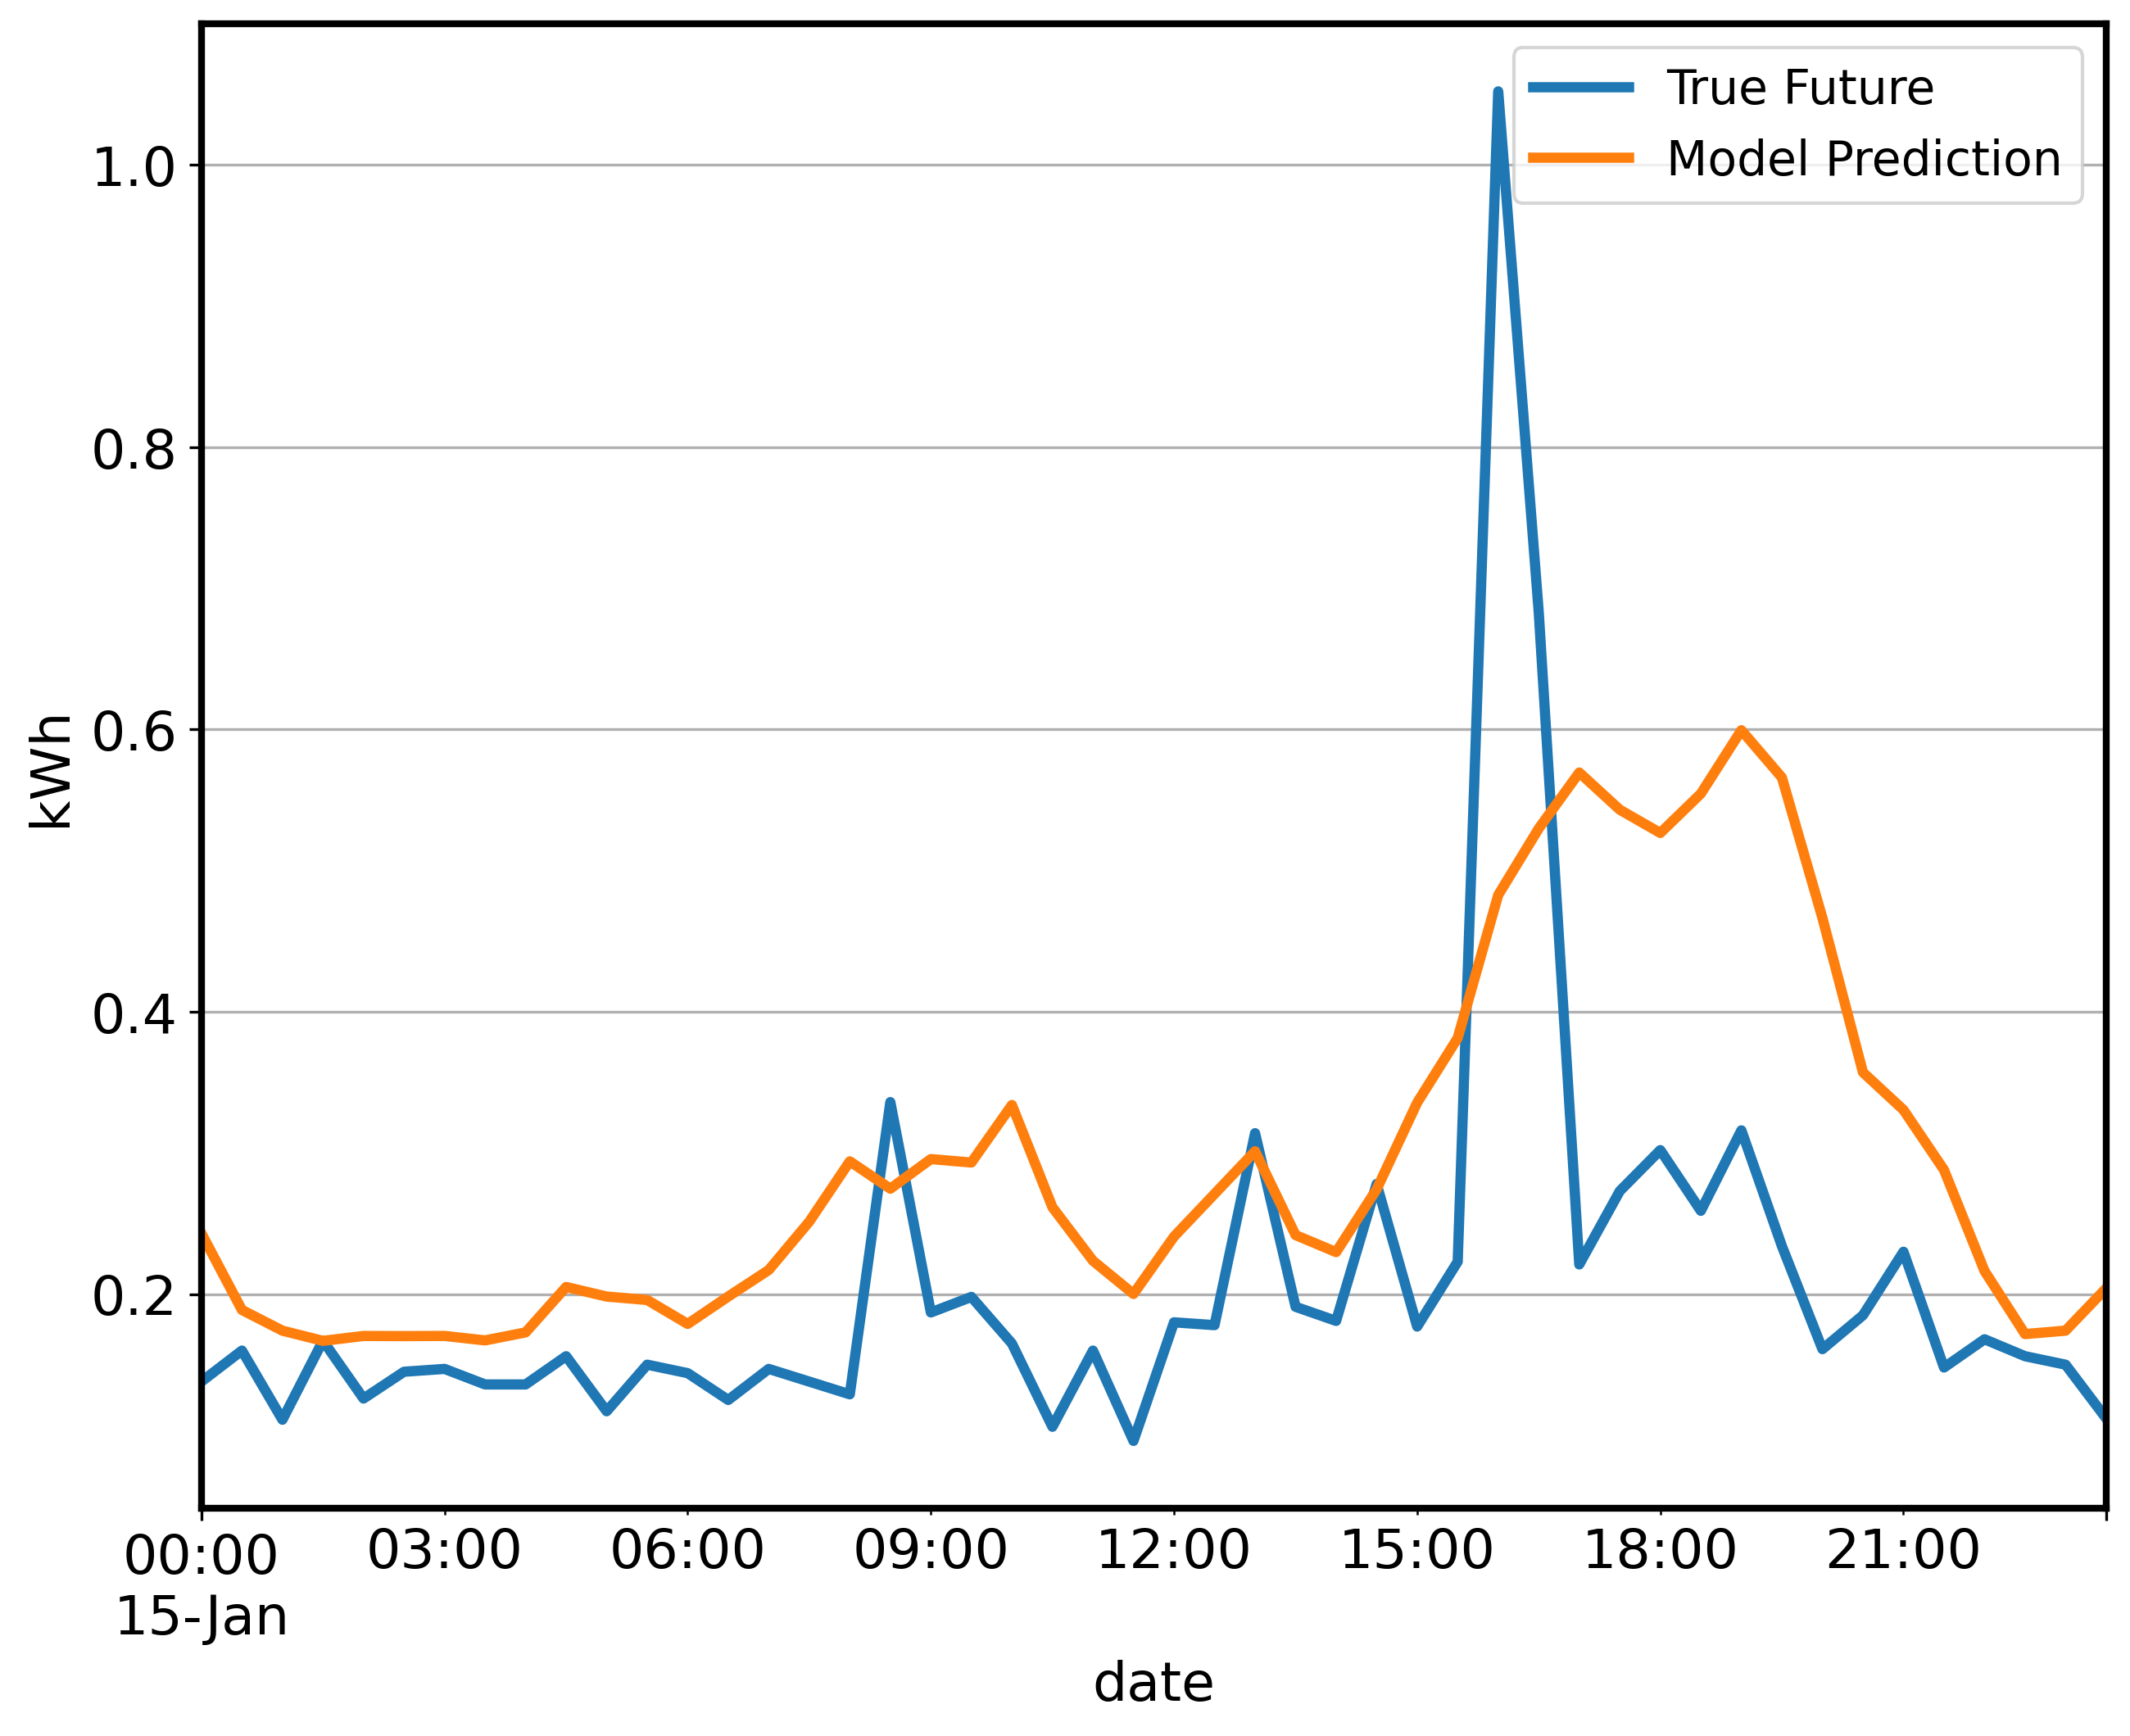

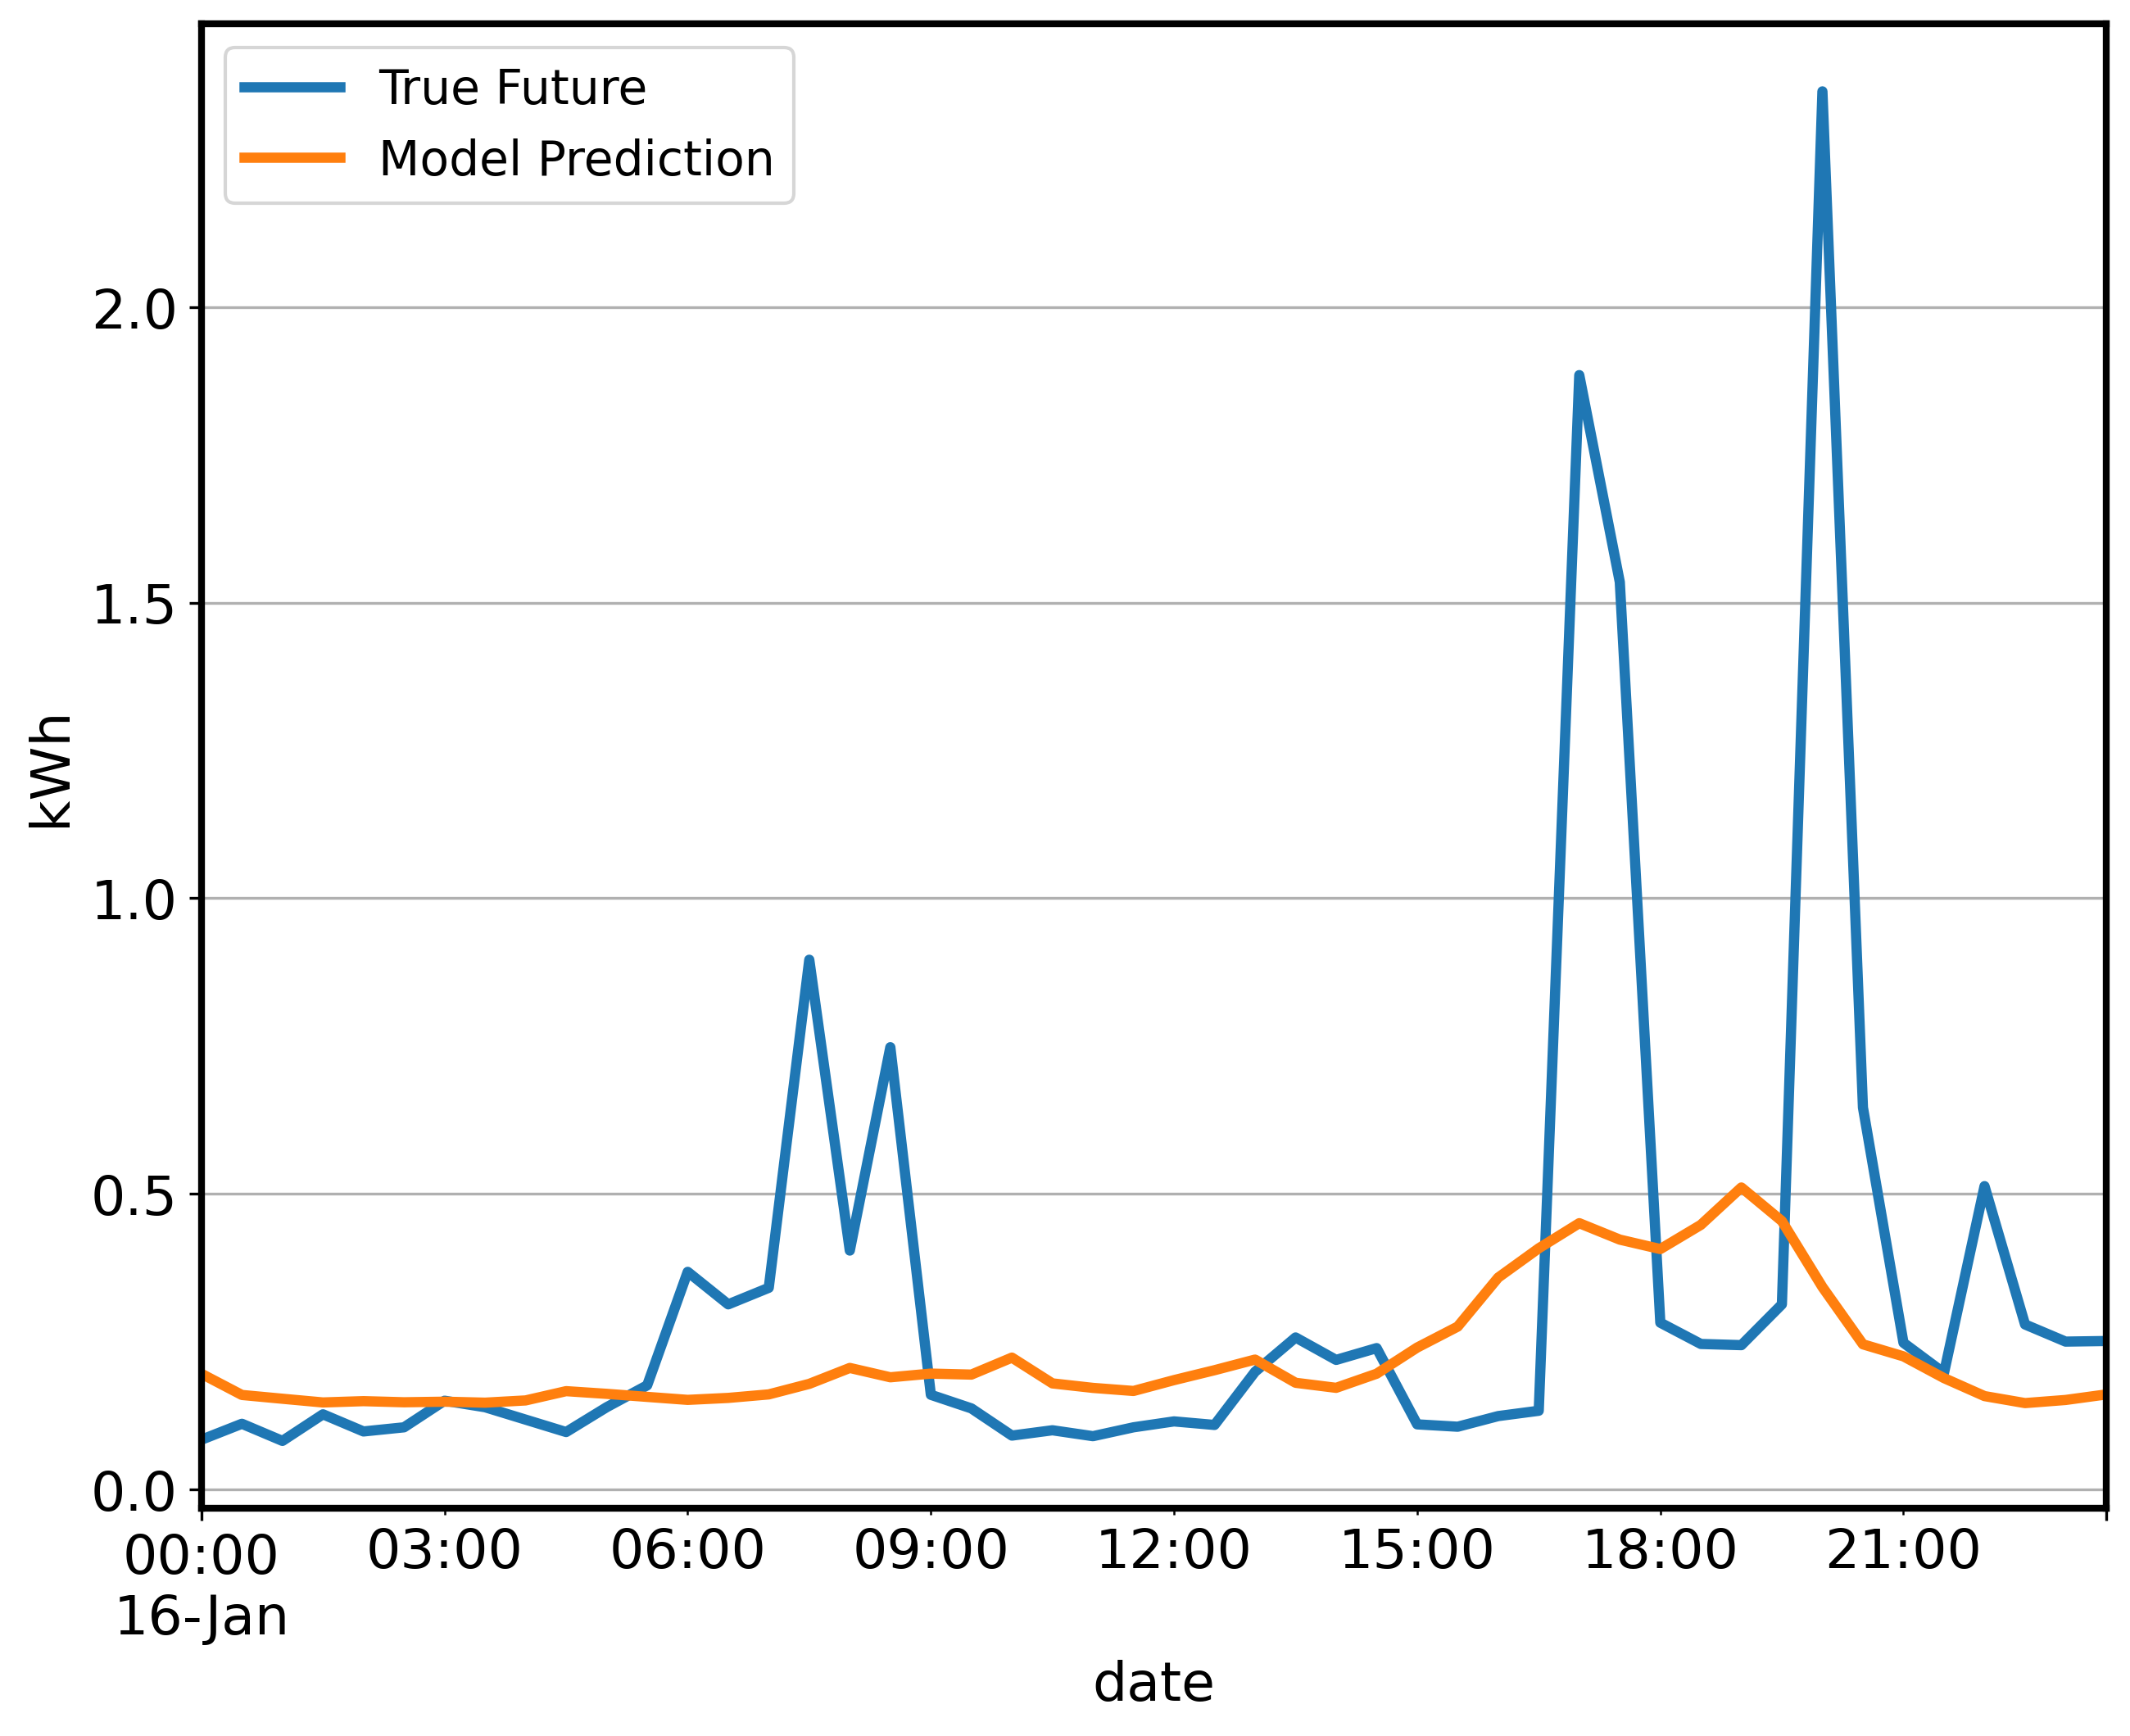

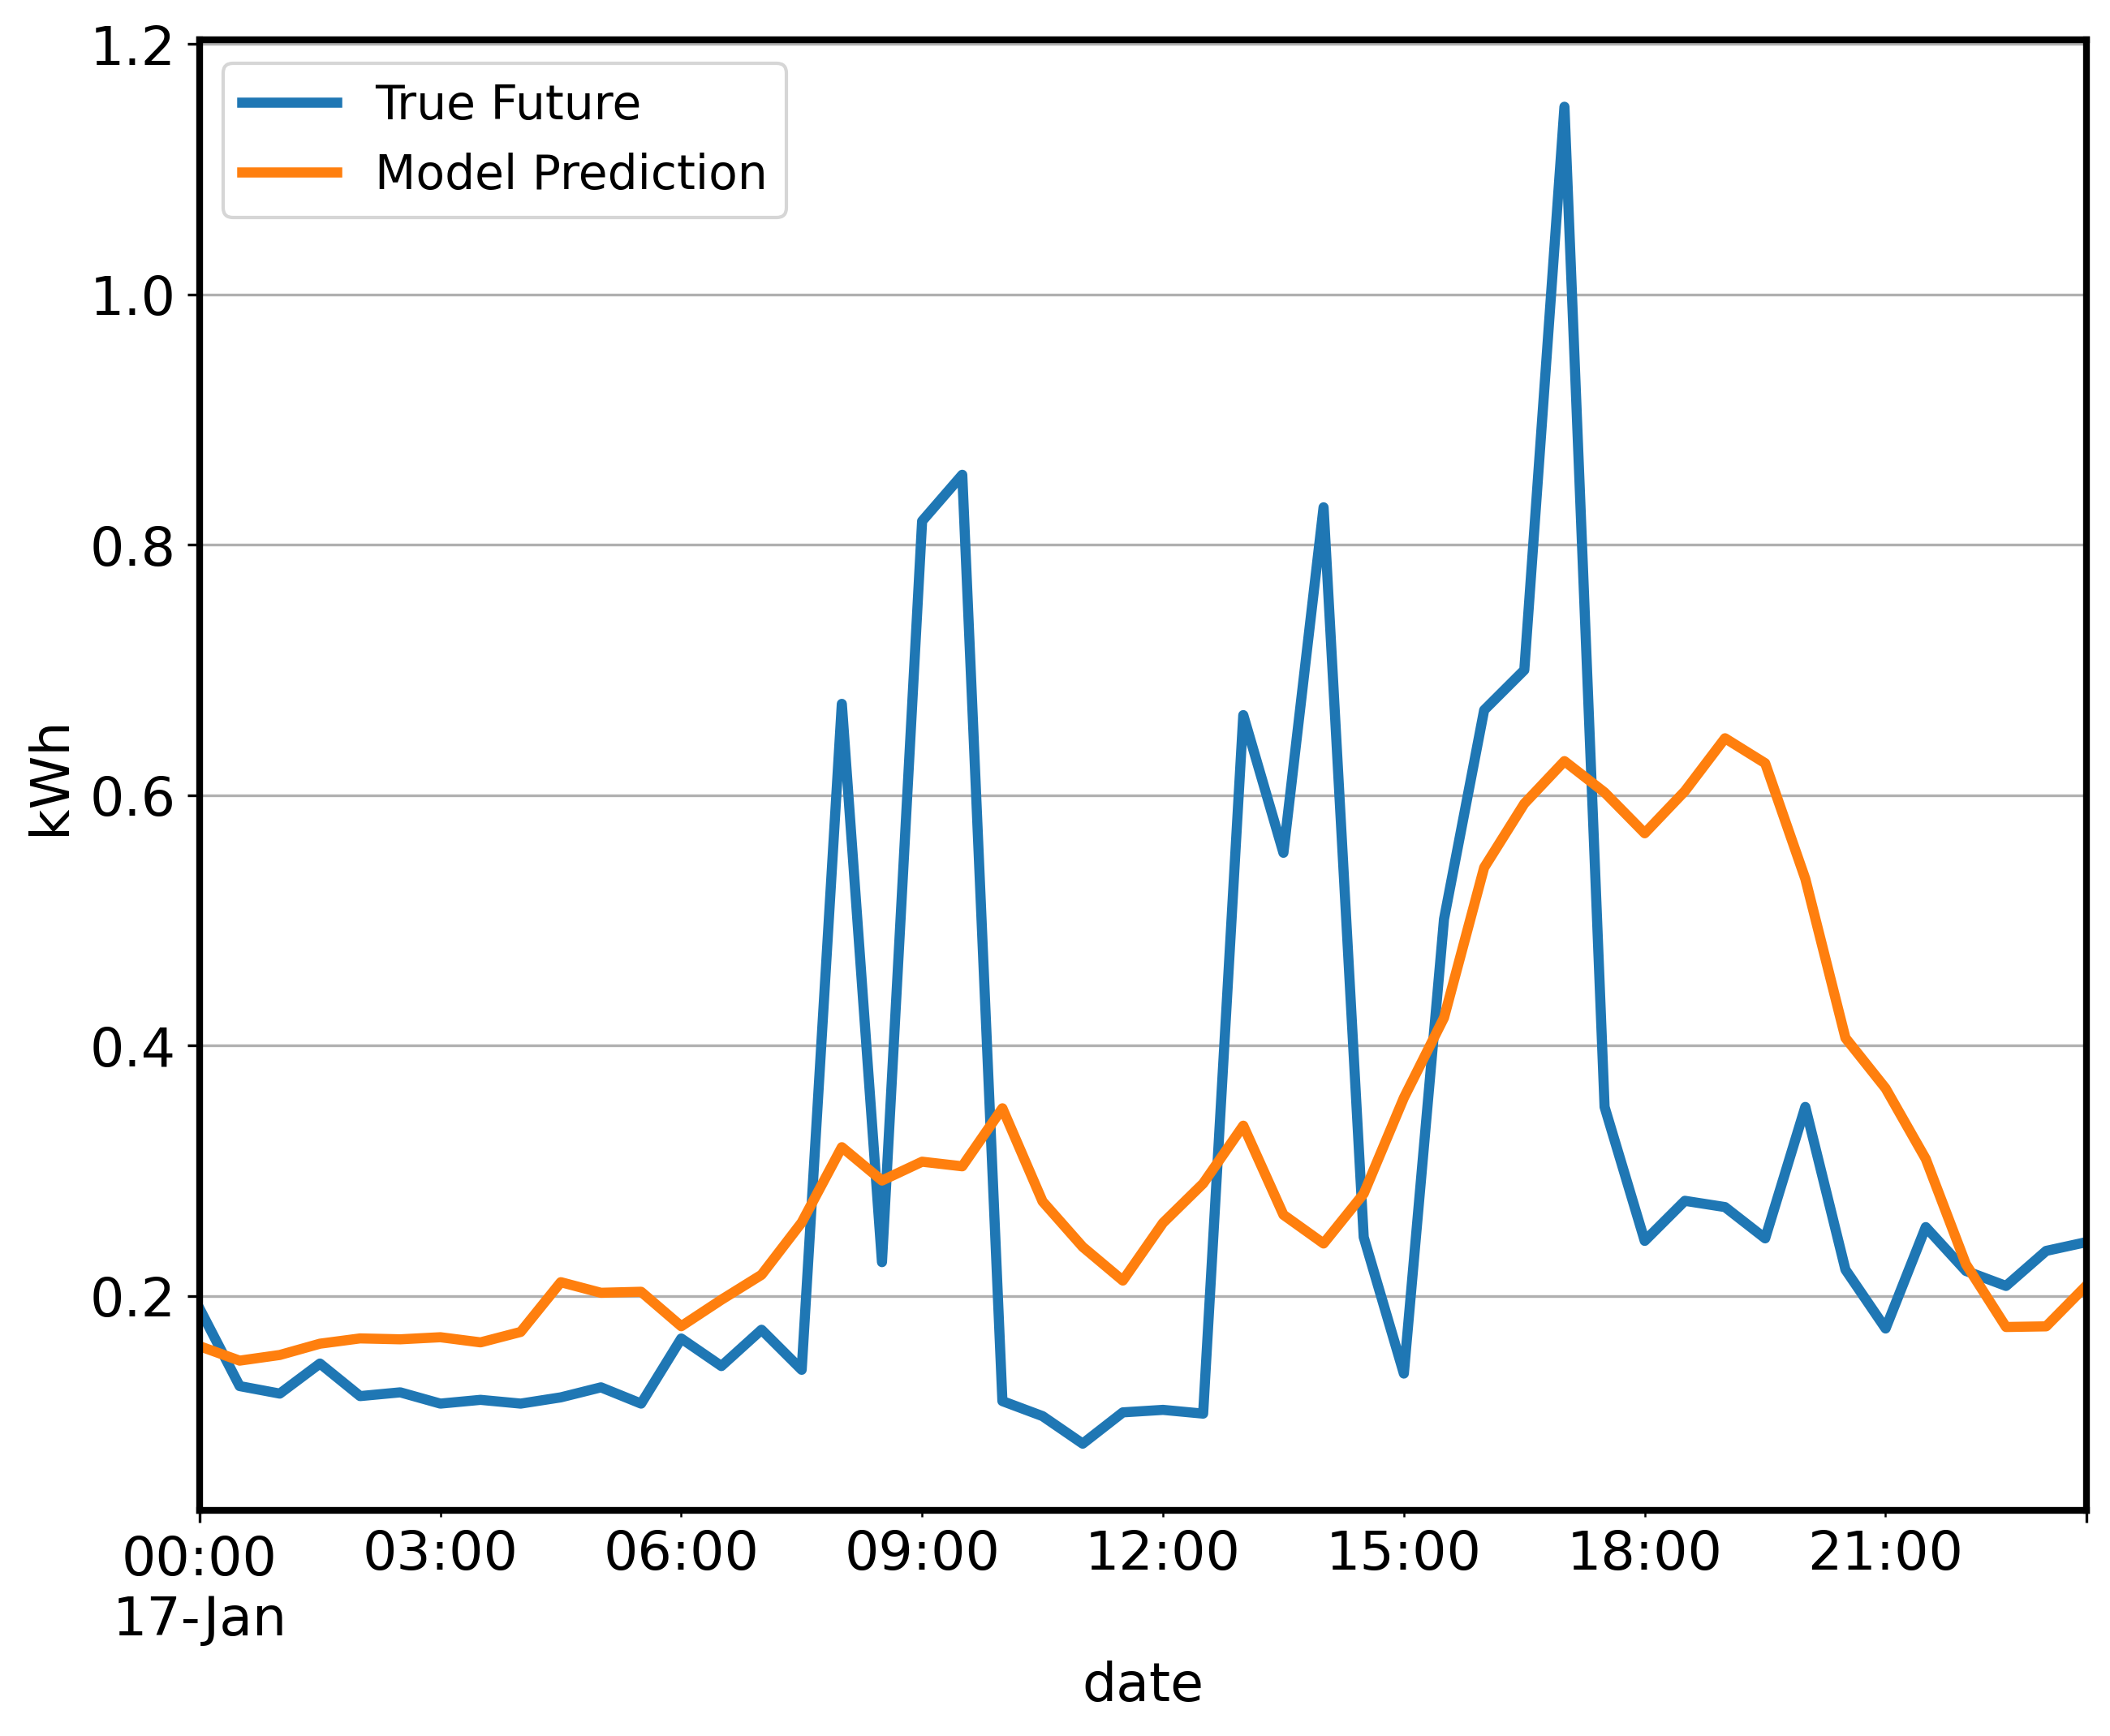

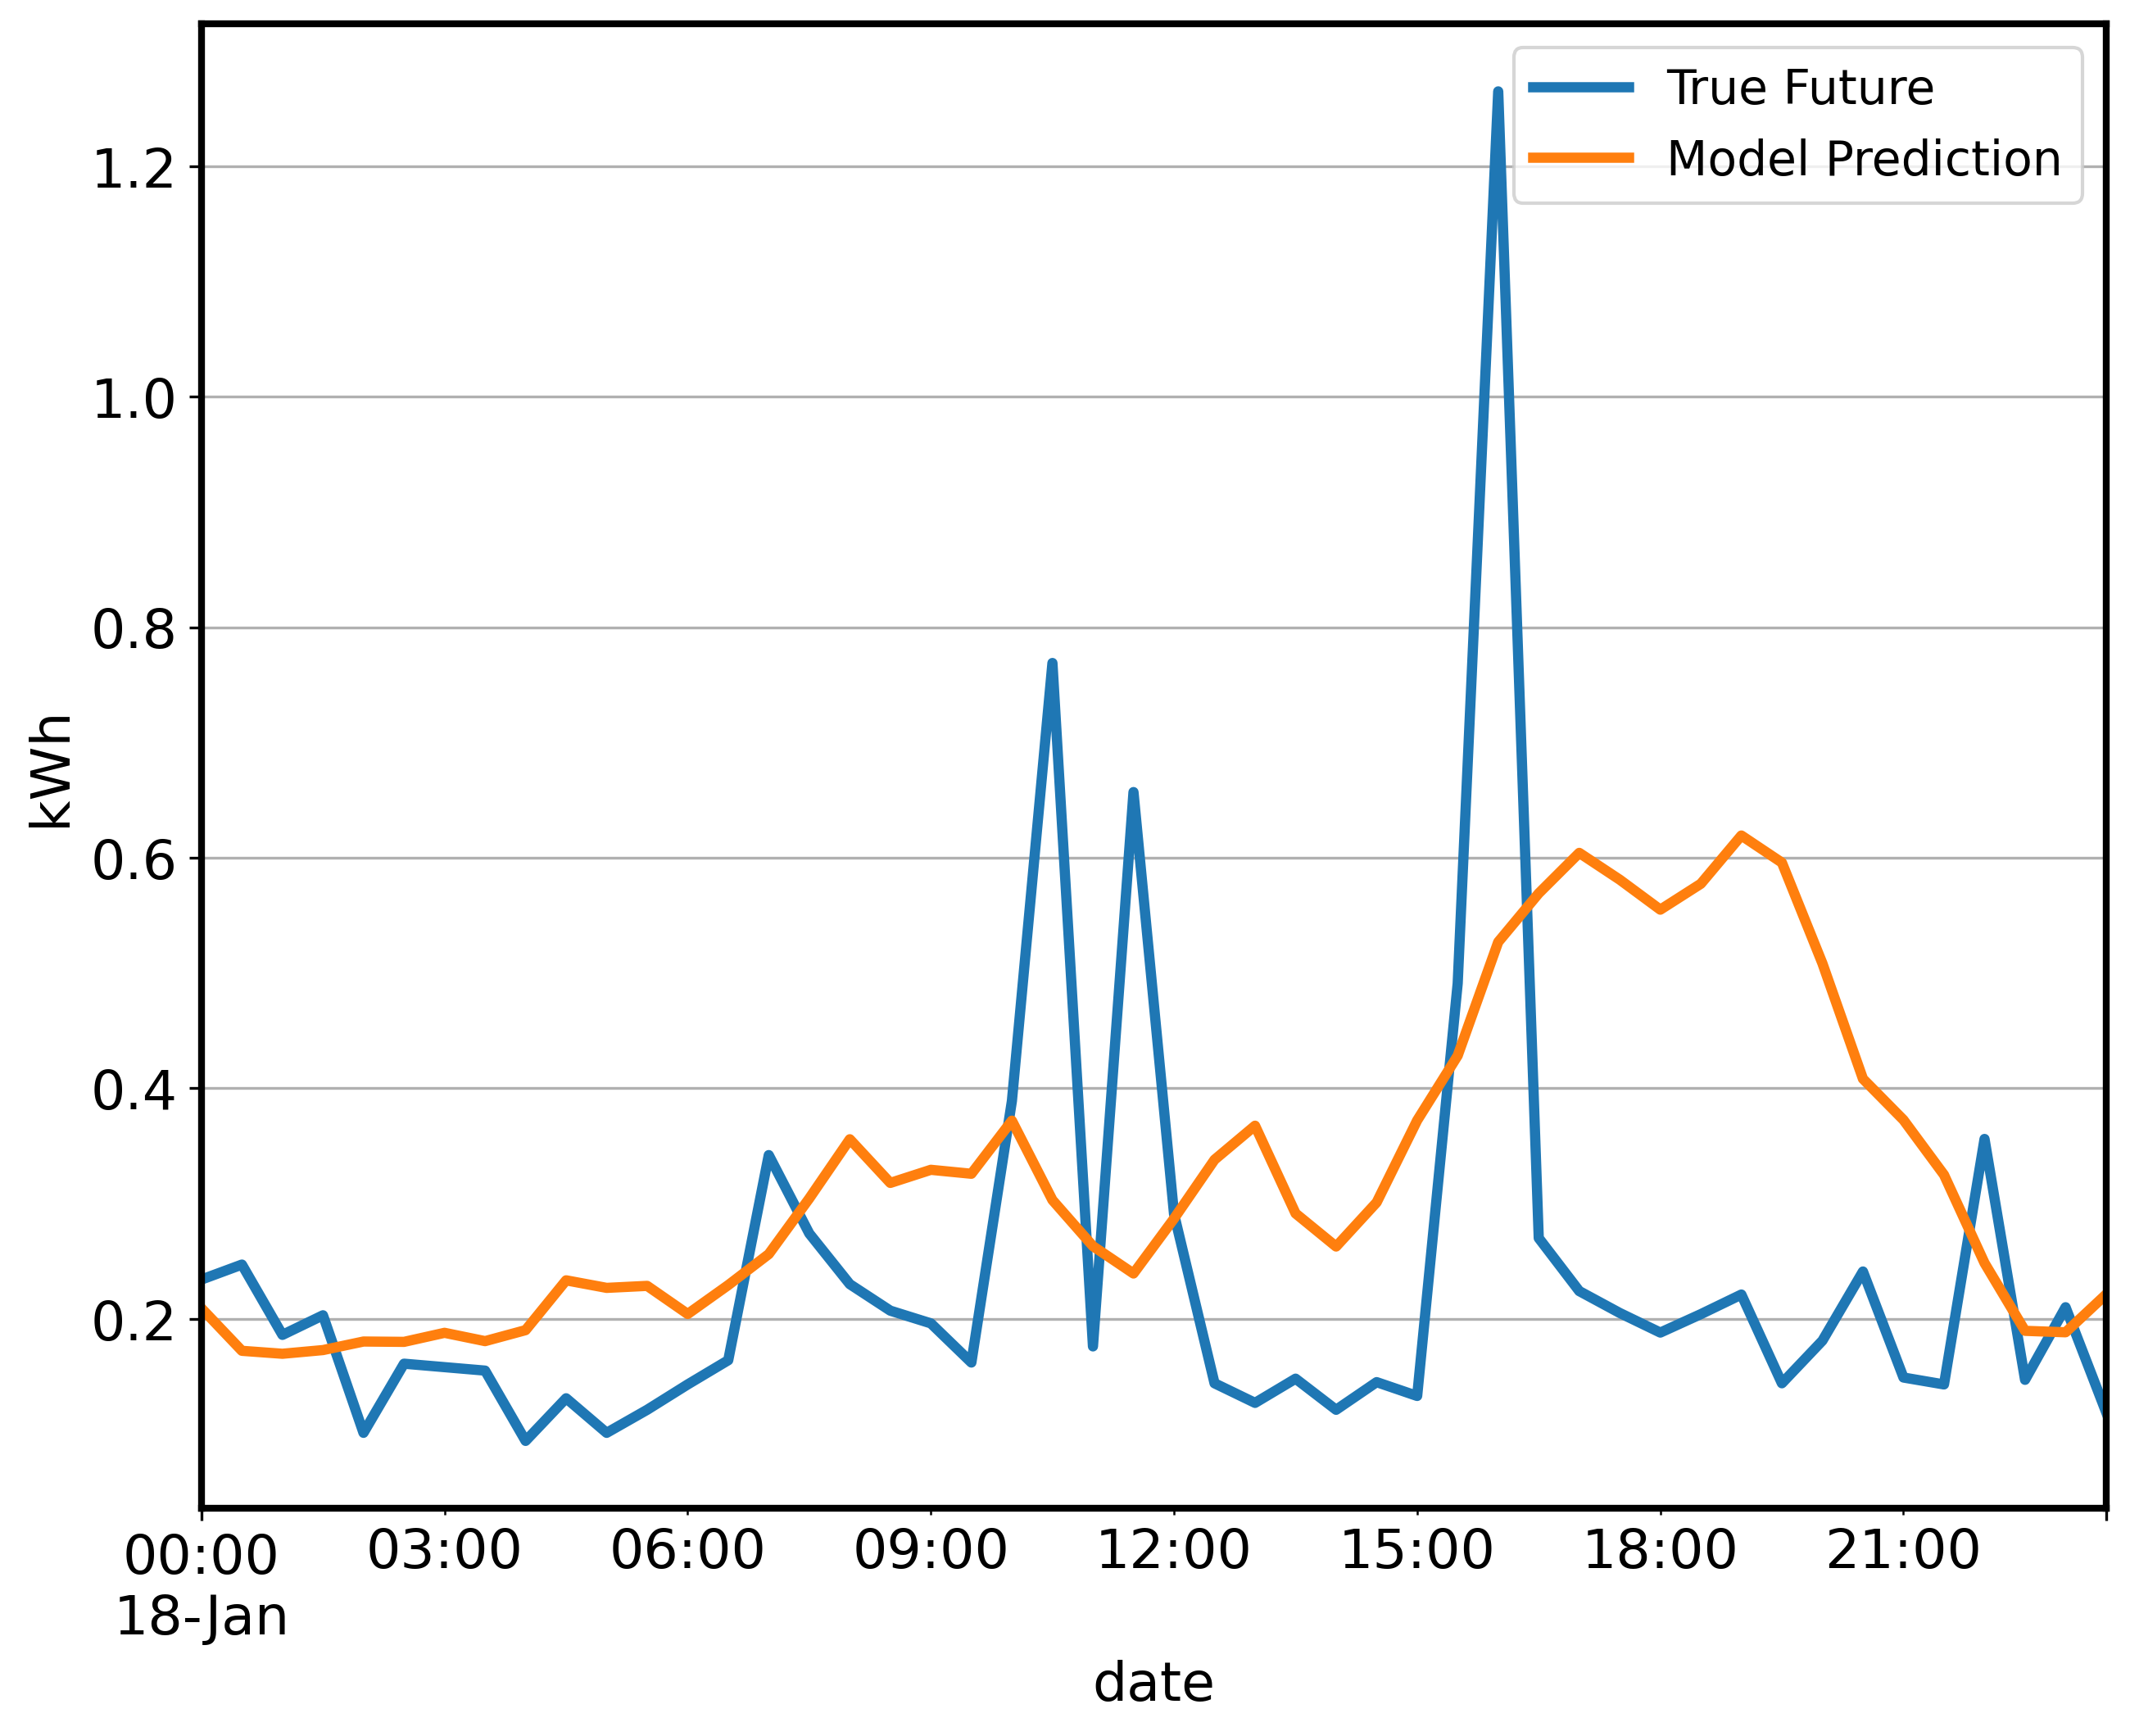

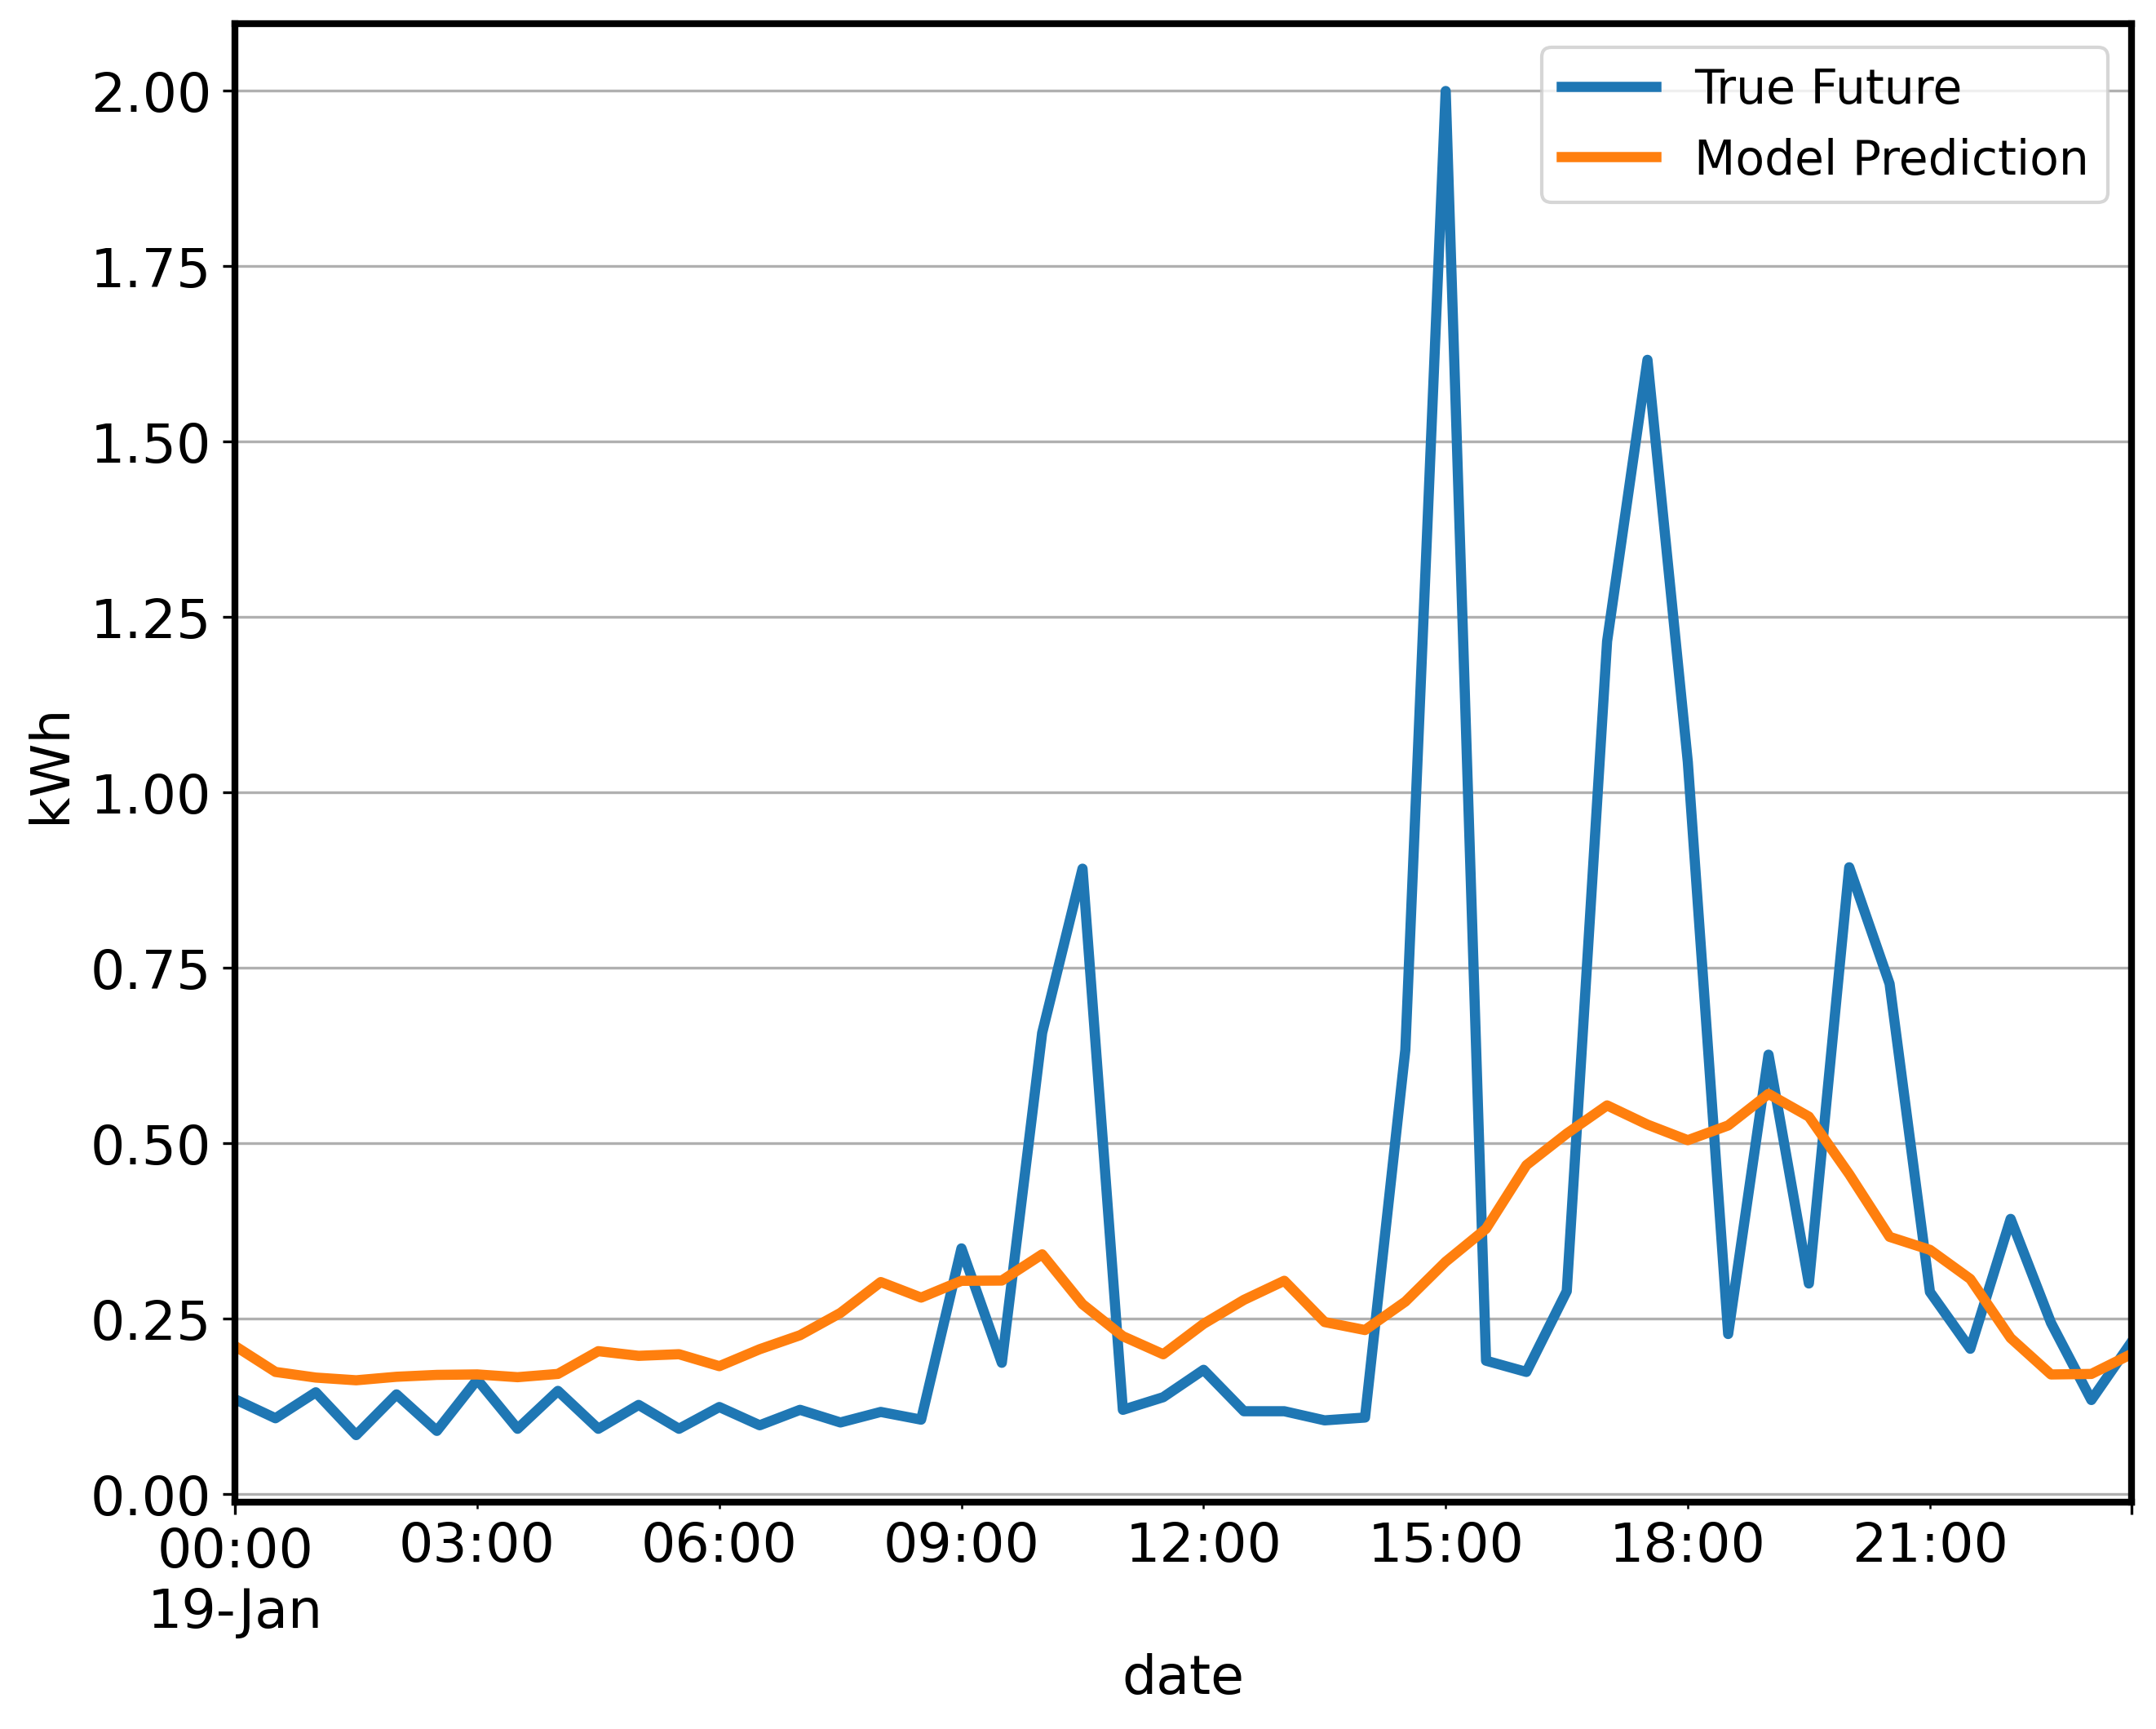

In [23]:
def show_forecast(all_predictions, all_references, ID: str, day_int: str, save: bool):
    axis = figure_layout(figsize=(10,8),titel="",xlabel="date",ylabel="kWh", dpi= 300)
    labels = ["True Future", "Model Prediction"]

    all_references.plot(ax=axis, lw= 3.0, grid= True)
    all_predictions.plot(ax=axis, lw= 3.0, grid= True)
    axis.legend(labels)

    if save:
        path = "Vanilla_LSTM_figures/"
        fname = path + "ID" + ID + "_Day" + day_int + ".png"
        plt.savefig(fname, dpi=None, facecolor='w', edgecolor='w', orientation='portrait', format=None,
                    transparent=False, bbox_inches='tight', pad_inches=0.1, metadata=None)

# show_forecast(all_predictions[0:48],all_references[0:48])

def show_all_forecasts(all_predictions, all_references,ID: str, save: bool = True):
    collection = get_all_days_of_year(all_predictions)
    for day_int in collection:
        predictions = all_predictions[all_predictions.index.dayofyear == day_int]
        references = all_references[all_references.index.dayofyear == day_int]
        show_forecast(predictions, references, ID, str(day_int), save)
    plt.show()

show_all_forecasts(all_predictions,all_references, time_serie1.name, True)

In [24]:
get_performance(all_predictions, all_references)

0.1318571822002579

In [ ]:
def repeated_performance(TS_norm_full: pd.Series, training: pd.Series, validation: pd.Series, test: pd.Series, temperature_norm: pd.Series, lag_value = 3, nb_epoch = 150, vb = 0, repeat = 2):
    collection = []
    for i in range(repeat):
        trained_model,hist = build_model_stateless1(training=training,validation=validation,temperature_norm=temperature_norm,lag_value=lag_value,nb_epoch=nb_epoch, verbose_para= vb)
        all_predictions, all_references = test_set_prediction(trained_model, TS_norm_full, temperature_norm, lag_value, test, True)
        p = get_performance(all_predictions, all_references)
        collection.append(p)
    return np.array(collection)
df = pd.DataFrame()
df[TS.name] = repeated_performance(TS_norm_full, training, validation, test, temperature_norm, lag_value = 3, nb_epoch = 150, vb = 0, repeat = 2)



In [ ]:
import time as t
results_file_name = str(t.time()) + ".txt"
results_file = open(results_file_name, "w")
results_file.write("This file displays the results of the hyperparameter search.")
results_file.close()


In [ ]:
df = pd.DataFrame(data= np.arange(0,25,2))
df["1"] = np.zeros(13)
df.describe()